<a target="_blank" href="https://colab.research.google.com/github/rypotter/multilingual-embeddings/blob/main/Multilingual_Embeddings_OpenAI_vs_OpenSource.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Fork from https://github.com/Yannael/multilingual-embeddings

Medium article: https://towardsdatascience.com/openai-vs-open-source-multilingual-embedding-models-e5ccb7c90f05

1. módosítás innen: https://github.com/jmbayu/multilingual-embeddings/tree/main

# OpenAI vs open-source multilingual embeddings models

This noteboook provides example code to assess which embedding model works best for your data. The example task is a retrieval task (as in RAG - retrieval augmented generation), on multilingual data. See associated Medium article [here](https://medium.com/p/e5ccb7c90f05).

The data source is based on the European AI Act, and models cover some of the latest OpenAI and open-source embeddings models (as of 02/2024) to deal with multilingual data:

OpenAI released [two models](https://openai.com/blog/new-embedding-models-and-api-updates) in January 2024:

- text-embedding-3-small (released 25/01/2024)
- text-embedding-3-large (released 25/01/2024)

We compare with the following open-source models

- [e5-mistral-7b-instruct](https://huggingface.co/intfloat/e5-mistral-7b-instruct) (released 04/01/2024)
- [multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct) (released 08/02/2024)
- [BGE-M3](https://huggingface.co/BAAI/bge-m3) (released 29/01/2024)
- [nomic-embed-text-v1](https://huggingface.co/nomic-ai/nomic-embed-text-v1) (released 10/02/2024)




# Install and import libraries

LlamaIndex will be used for loading embedding models and documents, and evaluate retrieval accuracy.

Seaborn will be used for visualization.

In [1]:
# FUTTATNI
%%capture

!pip install -q llama_index==0.10.1
!pip install -q html2text #Required for loading web pages with Llama index's SimpleWebPageReader
!pip install -q llama-index-readers-web #Required for loading web pages with Llama index's SimpleWebPageReader
!pip install -q transformers==4.37.2 # Required for open-source embeddings
!pip install -q openai # Required for GPT and OpenAI embeddings
!pip install -q einops #Required for nomic
!pip install -q seaborn #Required for visualization


In [2]:
# FUTTATNI
# MOD from jmbayu
# Detect GPU
import torch

# Check if CUDA is available and if a GPU is detected
if torch.cuda.is_available():
    print(f"Detected GPUs: {torch.cuda.device_count()}")
else:
    print("No GPU detected")

Detected GPUs: 1


Let us load the libraries/functions required for running this notebook

In [3]:
# FUTTATNI
import time
import json
import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm


Put your OpenAI API key here:

In [ ]:
OPENAI_API_KEY = "sk-..."
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Generate a multilingual Question/Answer dataset

We'll use the EU AI Act as the corpus. The text in different languages is available at All multilingual versions at https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:52021PC0206.

Available languages: "BG", "ES", "CS", "DA", "DE", "ET", "EL", "EN", "FR", "GA", "HR", "IT", "LV", "LT", "HU", "MT", "NL", "PL", "PT", "RO", "SK", "SL", "FI", "SV".

We'll use

- EN: English (Germanic)
- FR: French (Romance)
- CS: Czech (Slavic)
- HU: Hungarian (Uralic)


Useful documentation from Llama Index:
- https://docs.llamaindex.ai/en/latest/examples/data_connectors/WebPageDemo.html
- https://docs.llamaindex.ai/en/latest/examples/finetuning/embeddings/finetune_embedding.html#
- https://docs.llamaindex.ai/en/stable/api/llama_index.node_parser.SentenceSplitter.html


In [ ]:
from llama_index.readers.web import SimpleWebPageReader
from llama_index.core.node_parser import SentenceSplitter

language = "EN"
url_doc = "https://eur-lex.europa.eu/legal-content/"+language+"/TXT/HTML/?uri=CELEX:52021PC0206"

documents = SimpleWebPageReader(html_to_text=True).load_data([url_doc])

parser = SentenceSplitter(chunk_size=1000)
nodes = parser.get_nodes_from_documents(documents, show_progress=True)

len(nodes)

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

93

In [ ]:
# Example of text for the first chunck
nodes[0].text

### Prompts for generating questions and answers

We use the default prompt at: https://github.com/run-llama/llama_index/blob/c058f2531ea86ee74822cb1421ceaeee7098a99f/llama_index/finetuning/embeddings/common.py#L51

The French, Czech and Hungarian prompt were obtained using DeepL.

In [4]:
# FUTTATNI
prompts={}

prompts["EN"] = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and not prior knowledge, generate only questions based on the below query.

You are a Teacher/ Professor. Your task is to setup {num_questions_per_chunk} questions for an upcoming quiz/examination.
The questions should be diverse in nature across the document. Restrict the questions to the context information provided."
"""

prompts["FR"] = """\
Les informations contextuelles se trouvent ci-dessous.

---------------------
{context_str}
---------------------

Compte tenu des informations contextuelles et sans connaissances préalables, générer uniquement des questions basées sur la requête ci-dessous.

Vous êtes enseignant/professeur. Votre tâche consiste à mettre en place {num_questions_per_chunk} question(s) par requête pour un quiz à venir.
Les questions doivent être de nature variée sur l'ensemble du document. Limitez les questions aux informations contextuelles fournies.
Les questions doivent être en français.
"""

prompts["HU"] = """\
A kontextusra vonatkozó információk alább találhatók.

---------------------
{context_str}
---------------------

A kontextusinformáció és az előzetes ismeretek nélkül csak az alábbi lekérdezésen alapuló kérdéseket generáljon.

Ön tanár/professzor. Az Ön feladata, hogy {num_questions_per_chunk} kérdéseket állítson össze egy közelgő kvízhez/vizsgához.
A kérdéseknek változatos jellegűeknek kell lenniük az egész dokumentumban. Korlátozza a kérdéseket a megadott kontextus információkra.
A kérdéseknek magyarul kell megszólalniuk.
"""

prompts["CS"] = """\
Související informace naleznete níže.

---------------------
{context_str}
---------------------

Vzhledem ke kontextovým informacím a bez jakýchkoli předchozích znalostí vygenerujte pouze otázky na základě níže uvedeného dotazu.

Jste učitel. Vaším úkolem je sestavit {num_questions_per_chunk} otázek na jeden dotaz pro nadcházející kvíz.
Otázky musí být v celém dokumentu různorodé. Omezte otázky na uvedené kontextové informace.
Otázky by měly být v češtině.
"""

### Synthetic question/answer generation using OpenAI GPT3.5

We use gpt-3.5-turbo-0125, which is according to OpenAI the flagship model of this family, supports a 16K context window and is optimized for dialog (https://platform.openai.com/docs/models/gpt-3-5-turbo).

In [ ]:
# MOD from jmbayu
# ollama running on localhost:11434


In [ ]:
# MOD from jmbayu
from llama_index.llms.ollama import Ollama
llm = Ollama(model="llama3", request_timeout=120.0)
resp = llm.complete("Who is John Mbayu?")
print(resp)


In [ ]:
# MOD from jmbayu
from openai import OpenAI
import json
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

def to_dict(obj):
    return {attr: getattr(obj, attr) for attr in dir(obj) if not attr.startswith('__') and not callable(getattr(obj, attr))}


client = OpenAI( base_url='http://localhost:11434/v1/', api_key='ollama')

chat_completion = client.chat.completions.create(
    messages=[
        {
            'role': 'user',
            'content': 'Who is John Mbayu',
        }
    ],
    model='llama2',
    temperature=0.1,
    timeout = 1200.5
)

chat_completion_dict = to_dict(chat_completion)


#print(chat_completion_dict)

json_output = json.dumps(chat_completion_dict, indent=4, default=str)
# Colorize the JSON output
colorized_output = highlight(json_output, JsonLexer(), TerminalFormatter())

print(colorized_output)

In [ ]:
# MOD from jmbayu
from llama_index.llms.ollama import Ollama
from llama_index.legacy.finetuning import generate_qa_embedding_pairs

qa_dataset = generate_qa_embedding_pairs(
    llm=Ollama(
        model="llama3",
        url="http://localhost:11434",
        request_timeout=1200.0, additional_kwargs={'seed':42}),
    nodes=nodes[:3],
    qa_generate_prompt_tmpl = prompts[language],
    num_questions_per_chunk=2
)

file_name=language+"_dataset.json"
qa_dataset.save_json(file_name)

In [ ]:
# MOD from jmbayu - Vajjon müxik ez???
#from llama_index.llms import OpenAI
from llama_index.llms.openai import OpenAI
from llama_index.legacy.finetuning import generate_qa_embedding_pairs

qa_dataset = generate_qa_embedding_pairs(
    llm=OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama_required_but_ignored',
    model="llama3",additional_kwargs={'seed':42}),
    nodes=nodes,
    qa_generate_prompt_tmpl = prompts[language],
    num_questions_per_chunk=2
)

file_name=language+"_dataset.json"
qa_dataset.save_json(file_name)

In [ ]:
#from llama_index.llms import OpenAI
from llama_index.llms.openai import OpenAI
from llama_index.legacy.finetuning import generate_qa_embedding_pairs

qa_dataset = generate_qa_embedding_pairs(
    llm=OpenAI(model="gpt-3.5-turbo-0125",additional_kwargs={'seed':42}),
    nodes=nodes,
    qa_generate_prompt_tmpl = prompts[language],
    num_questions_per_chunk=2
)

file_name=language+"_dataset.json"
qa_dataset.save_json(file_name)

 19%|█▉        | 36/190 [02:58<04:34,  1.78s/it]

### Load dataset from JSON file

Data can be reloaded from their JSON file with the EmbeddingQAFinetuneDataset object.

In [ ]:
# TESZT LEHET?
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset

language = "EN"
file_name=language+"_dataset.json"
qa_dataset = EmbeddingQAFinetuneDataset.from_json(file_name)

In [ ]:
list(qa_dataset.queries.values())[0:2]

['What are the main objectives of the proposal for a Regulation laying down harmonised rules on artificial intelligence (Artificial Intelligence Act) according to the explanatory memorandum?',
 'How does the proposal for a Regulation on artificial intelligence aim to address the risks associated with the use of AI while promoting the uptake of AI in the European Union, as outlined in the context information?']

# Evaluate OpenAI embedding models

The code inspired from https://docs.llamaindex.ai/en/stable/examples/finetuning/embeddings/finetune_embedding.html

The function `evaluate` assesses the performance of a text embedding model on a given dataset for information retrieval tasks. Assessment is in terms of MRR (Mean Reciprocal Rank)

In [ ]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import TextNode
from llama_index.core import VectorStoreIndex

def evaluate(dataset, embed_model, insert_batch_size=1000, top_k=5):
    # Get corpus, queries, and relevant documents from the qa_dataset object
    corpus = dataset.corpus
    queries = dataset.queries
    relevant_docs = dataset.relevant_docs

    # Create TextNode objects for each document in the corpus and create a VectorStoreIndex to efficiently store and retrieve embeddings
    nodes = [TextNode(id_=id_, text=text) for id_, text in corpus.items()]
    index = VectorStoreIndex(
        nodes, embed_model=embed_model, insert_batch_size=insert_batch_size
    )
    retriever = index.as_retriever(similarity_top_k=top_k)

    # Prepare to collect evaluation results
    eval_results = []

    # Iterate over each query in the dataset to evaluate retrieval performance
    for query_id, query in tqdm(queries.items()):
        # Retrieve the top_k most similar documents for the current query and extract the IDs of the retrieved documents
        retrieved_nodes = retriever.retrieve(query)
        retrieved_ids = [node.node.node_id for node in retrieved_nodes]

        # Check if the expected document was among the retrieved documents
        expected_id = relevant_docs[query_id][0]
        is_hit = expected_id in retrieved_ids  # assume 1 relevant doc per query

        # Calculate the Mean Reciprocal Rank (MRR) and append to results
        if is_hit:
            rank = retrieved_ids.index(expected_id) + 1
            mrr = 1 / rank
        else:
            mrr = 0
        eval_results.append(mrr)

    # Return the average MRR across all queries as the final evaluation metric
    return np.average(eval_results)

In [ ]:
embeddings_model_spec = {
}

embeddings_model_spec['OAI-Large-256']={'model_name':'text-embedding-3-large','dimensions':256, 'batch_size':512}
embeddings_model_spec['OAI-Large-3072']={'model_name':'text-embedding-3-large','dimensions':3072, 'batch_size':512}
embeddings_model_spec['OAI-Small']={'model_name':'text-embedding-3-small','dimensions':1536, 'batch_size':512}
embeddings_model_spec['OAI-ada-002']={'model_name':'text-embedding-ada-002','dimensions':None, 'batch_size':512}


In [ ]:
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.embeddings.openai import OpenAIEmbedding

results = []

languages = ["FR", "EN"]
languages = ["EN"]

# Loop through all languages
for language in languages:

    # Load dataset
    file_name=language+"_dataset.json"
    qa_dataset = EmbeddingQAFinetuneDataset.from_json(file_name)

    # Loop through all models
    for model_name, model_spec in embeddings_model_spec.items():

        print("Processing model : "+str(model_spec))

        # Get model
        embed_model = OpenAIEmbedding(model=model_spec['model_name'],
                                      embed_batch_size=model_spec['batch_size'],
                                      dimensions=model_spec['dimensions']
                                     )

        start_time_assessment=time.time()

        # Assess embedding score (in terms of MRR)
        score = evaluate(qa_dataset, embed_model)

        # Get duration of score assessment
        duration_assessment = time.time()-start_time_assessment

        results.append([language, model_name, score, duration_assessment])


In [ ]:
df = pd.DataFrame(results, columns = ["Language" ,"Embedding model", "MRR", "Duration"])

In [ ]:
df.to_pickle("results_openai.pkl")

## Plotting

Let us plot the results using the Seaborn library

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Embedding model", y="MRR", hue="Language", data=df, palette="viridis")

plt.xlabel('Embedding Model')
plt.ylabel('MRR  (Mean Reciprocal Rank)')
plt.title('MRR by Model and Language')
plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability
plt.ylim(0, 0.8)

plt.legend(title='Language')
plt.tight_layout()  # Adjust layout
plt.show()

# Evaluate open-source models

## Install and import libraries

Let us additionally install

- sentence-transformers : For using the util.semantic_search function
- bitsandbytes : For loading quantized models
- accelerate : For more efficient model loading

In [5]:
# FUTTATNI
%%capture

!pip install -q sentence-transformers bitsandbytes accelerate

In [6]:
# FUTTATNI
import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import util

## Pooling functions

Two main types of pooling functions: 'mean' and 'cls' (see https://blog.ml6.eu/the-art-of-pooling-embeddings-c56575114cf8).

E5_Mistral additionally relies on 'last_token' pooling, see model card: https://huggingface.co/intfloat/e5-mistral-7b-instruct

In [7]:
# FUTTATNI
def mean_pooling(model_output):
    return torch.mean(model_output["last_hidden_state"], dim=1)

def cls_pooling(model_output):
    return model_output[0][:, 0]

def last_token_pooling(model_output):
    return model_output[0][:, -1]

def get_sentence_embedding(text, tokenizer, embed_model, normalize, max_length, pooling_type='cls'):

    if pooling_type=="last_token":
        encoded_input = tokenizer(text, max_length=max_length, return_attention_mask=False, padding=False, truncation=True)
        encoded_input['input_ids'] = encoded_input['input_ids'] + [tokenizer.eos_token_id]
        encoded_input = tokenizer.pad([encoded_input], padding=True, return_attention_mask=True, return_tensors='pt').to("cuda")
    else:
        encoded_input = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True).to("cuda")

    with torch.no_grad():
        model_output = embed_model(**encoded_input)

    if pooling_type=="cls":
        sentence_embeddings = cls_pooling(model_output)
    if pooling_type=="mean":
        sentence_embeddings = mean_pooling(model_output)
    if pooling_type=="last_token":
        sentence_embeddings = last_token_pooling(model_output)

    if normalize:
        sentence_embeddings = F.normalize(sentence_embeddings)

    return sentence_embeddings


## Evaluation function

We slightly modify the evaluation function to avoid using the Llama Index wrapper for embedding, which does not support 'last_token' embedding. Top k results are computed using the util.semantic_search function.

In [8]:
# FUTTATNI
def evaluate(qa_dataset, tokenizer, embed_model, normalize, max_length=None, pooling_type="cls", top_k=5, verbose=False):

    # Get corpus and queries, and relevant documents from the qa_dataset object
    input_texts = list(qa_dataset.corpus.values())
    input_text_keys = list(qa_dataset.corpus.keys())
    queries = qa_dataset.queries
    relevant_docs = qa_dataset.relevant_docs

    # Compute embeddings for each document in the corpus
    embeddings = [get_sentence_embedding(sentence, tokenizer, embed_model, normalize, max_length, pooling_type)
                  for sentence in input_texts]
    embeddings = torch.cat(embeddings)

    # Prepare to collect evaluation results
    eval_results = []

    # Iterate over each query in the dataset to evaluate retrieval performance
    for query_id, query in tqdm(queries.items()):

        # Retrieve the top_k most similar documents for the current query and extract the IDs of the retrieved documents
        query_embedding = get_sentence_embedding(query, tokenizer, embed_model, normalize, max_length, pooling_type)
        results = util.semantic_search(query_embedding, embeddings, top_k=top_k)[0]
        retrieved_ids = [input_text_keys[int(result["corpus_id"])] for result in results]

        # Check if the expected document was among the retrieved documents
        expected_id = relevant_docs[query_id][0]
        is_hit = expected_id in retrieved_ids  # assume 1 relevant doc

        # Calculate the Mean Reciprocal Rank (MRR) and append to results
        if is_hit:
            rank = retrieved_ids.index(expected_id) + 1
            mrr = 1 / rank
        else:
            mrr = 0
        eval_results.append(mrr)

    # Return the average MRR across all queries as the final evaluation metric
    return np.average(eval_results)



The code follows the same logic as for OpenAI embeddings: loop through all models and languages and compute MRR.

In [9]:
# FUTTATNI
embeddings_model_spec = {
}

#embeddings_model_spec['E5-mistral-7b']={'model_name':'intfloat/e5-mistral-7b-instruct','max_length':32768, 'pooling_type':'last_token',
#                                        'normalize': True, 'batch_size':1, 'kwargs': {'load_in_4bit':True, 'bnb_4bit_compute_dtype':torch.float16}}

embeddings_model_spec['PULI-GPT-3SX']={'model_name': 'NYTK/PULI-GPT-3SX','max_length':2048, 'pooling_type':'mean',
                                      'normalize': True, 'batch_size':1, 'kwargs': {'device_map': 'cuda', 'torch_dtype':torch.float16}}

embeddings_model_spec['ML-E5-large']={'model_name':'intfloat/multilingual-e5-large','max_length':512, 'pooling_type':'mean',
                                      'normalize': True, 'batch_size':1, 'kwargs': {'device_map': 'cuda', 'torch_dtype':torch.float16}}
embeddings_model_spec['BGE-M3']={'model_name':'BAAI/bge-m3','max_length':8192, 'pooling_type':'cls',
                                 'normalize': True, 'batch_size':1, 'kwargs': {'device_map': 'cuda', 'torch_dtype':torch.float16}}
embeddings_model_spec['Nomic-Embed']={'model_name':'nomic-ai/nomic-embed-text-v1','max_length':8192, 'pooling_type':'mean',
                                      'normalize': True, 'batch_size':1, 'kwargs': {'device_map': 'cuda', 'trust_remote_code' : True}}


In [10]:
# FUTTATNI
# Letölteni a ..._dataset.json-okat
!git clone https://github.com/rypotter/multilingual-embeddings.git

#languages = ["EN", "FR", "CS", "HU"]

#file_name="multilingual-embeddings/"+"HU"+"_dataset.json"
!ls -al 'multilingual-embeddings/'


Cloning into 'multilingual-embeddings'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 38 (delta 18), reused 16 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 898.56 KiB | 2.83 MiB/s, done.
Resolving deltas: 100% (18/18), done.
total 3492
drwxr-xr-x 3 root root   4096 Nov 12 12:14 .
drwxr-xr-x 1 root root   4096 Nov 12 12:14 ..
-rw-r--r-- 1 root root 742759 Nov 12 12:14 CS_dataset.json
-rw-r--r-- 1 root root 499902 Nov 12 12:14 EN_dataset.json
-rw-r--r-- 1 root root 681367 Nov 12 12:14 FR_dataset.json
drwxr-xr-x 8 root root   4096 Nov 12 12:14 .git
-rw-r--r-- 1 root root 822598 Nov 12 12:14 HU_dataset.json
-rw-r--r-- 1 root root 790979 Nov 12 12:14 Multilingual_Embeddings_OpenAI_vs_OpenSource.ipynb
-rw-r--r-- 1 root root   1404 Nov 12 12:14 README.md
-rw-r--r-- 1 root root   1164 Nov 12 12:14 results_openai.pkl
-rw-r--r-- 1 root root   1158 Nov 12 12:14 results_ope

In [ ]:
# PULI próba
from transformers import GPTNeoXForCausalLM, AutoTokenizer

model = GPTNeoXForCausalLM.from_pretrained("NYTK/PULI-GPT-3SX")
tokenizer = AutoTokenizer.from_pretrained("NYTK/PULI-GPT-3SX")
prompt = "Elmesélek egy történetet a nyelvtechnológiáról."
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

gen_tokens = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.9,
    max_length=100,
)

gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text)

In [ ]:
# FUTTATNI
# SAJNOS: OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 49.06 MiB is free.
# Process 15367 has 14.70 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 316.17 MiB is reserved by PyTorch but unallocated.
# If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.
# See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

from llama_index.core.evaluation import EmbeddingQAFinetuneDataset

#!export 'PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True'

results = []

languages = ["EN", "FR", "CS", "HU"]

# Loop through all models
for model_name, model_spec in embeddings_model_spec.items():

    print("Processing model : "+str(model_spec))

    # Get model
    tokenizer = AutoTokenizer.from_pretrained(model_spec['model_name'])
    embed_model = AutoModel.from_pretrained(model_spec['model_name'], **model_spec['kwargs'])

    if model_name=="Nomic-Embed":
        embed_model.to('cuda')

    # Loop through all languages
    for language in languages:

        # Load dataset
        file_name="multilingual-embeddings/"+language+"_dataset.json"
        qa_dataset = EmbeddingQAFinetuneDataset.from_json(file_name)

        start_time_assessment=time.time()

        # Assess embedding score (in terms of hit rate at k=5)
        score = evaluate(qa_dataset, tokenizer, embed_model, model_spec['normalize'], model_spec['max_length'], model_spec['pooling_type'])

        # Get duration of score assessment
        duration_assessment = time.time()-start_time_assessment

        results.append([language, model_name, score, duration_assessment])


In [ ]:
# FUTTATNI
df = pd.DataFrame(results, columns = ["Language" ,"Embedding model", "MRR", "Duration"])
df.to_pickle("results_open_source.pkl")

## Plotting

Let us plot the results using the Seaborn library

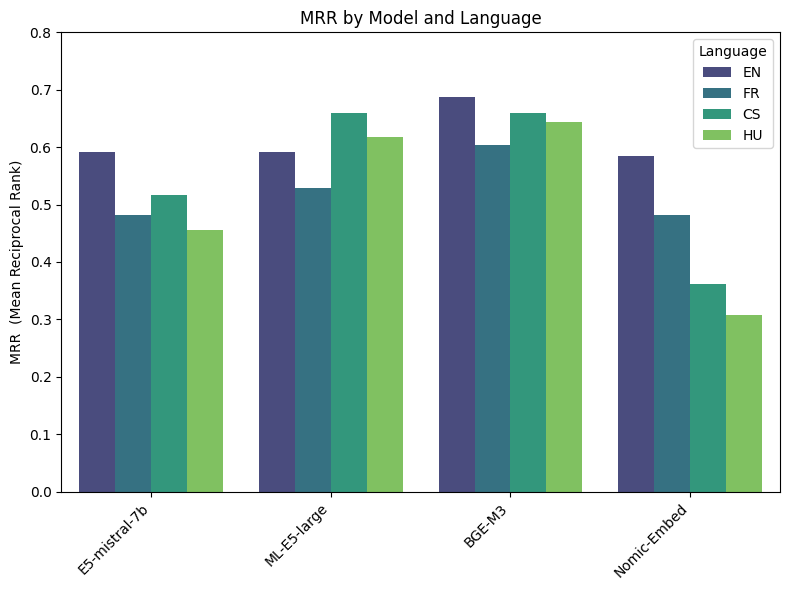

In [ ]:
# FUTTATNI
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Embedding model", y="MRR", hue="Language", data=df, palette="viridis")

plt.xlabel('')
plt.ylabel('MRR  (Mean Reciprocal Rank)')
plt.title('MRR by Model and Language')
plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability
plt.ylim(0, 0.8)

plt.legend(title='Language')
plt.tight_layout()  # Adjust layout
plt.show()

Let us plot the processing time per model for English language

In [ ]:
df_english=df[df['Language']=="EN"]

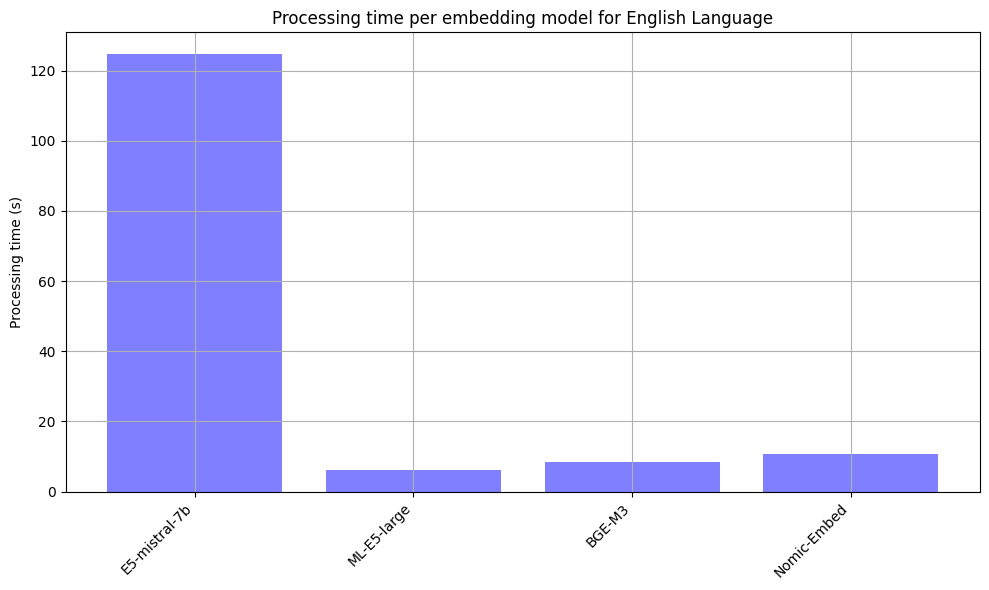

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df_english["Embedding model"], df_english["Duration"], color='blue', alpha=0.5)
plt.title('Processing time per embedding model for English Language')
#plt.xlabel('Embedding Model')
plt.ylabel('Processing time (s)')
plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability

plt.grid(True)
plt.tight_layout()  # Adjust layout
plt.show()

# Combine all MRR

Let us finally combine the mean reciprocal ranks of all models/languages in a single figure.

In [ ]:
df_open_source = pd.read_pickle("results_open_source.pkl")
df_openai = pd.read_pickle("results_openai.pkl")
df = pd.concat([df_openai, df_open_source])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Embedding model", y="MRR", hue="Language", data=df, palette="viridis")

plt.xlabel('')
plt.ylabel('MRR  (Mean Reciprocal Rank)')
plt.title('MRR by Model and Language')
plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability
plt.ylim(0, 0.8)

plt.legend(title='Language')
plt.grid(True)
plt.tight_layout()  # Adjust layout
plt.show()

# Additional resources

- Related Medium post:
- [Finetune embedding models with LlamaIndex](https://docs.llamaindex.ai/en/latest/examples/finetuning/embeddings/finetune_embedding.html#)
- https://medium.com/towards-data-science/how-to-find-the-best-multilingual-embedding-model-for-your-rag-40325c308ebb
